In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pandas as pd

from plotter import *

In [2]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [3]:
year = '2018'
nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
outsum = processor.dict_accumulator()

In [4]:
# Load all files
for n in range(1,nfiles+1):

    with open('infiles-split/'+year+'_'+str(n)+'.json') as f:
      infiles = json.load(f)
    
    filename = '/myeosdir/inclusive/outfiles/'+year+'_'+str(n)+'.coffea'
    #filename = 'outfiles/'+year+'_'+str(n)+'.coffea'
    if os.path.isfile(filename):
        out = util.load(filename)
        outsum.add(out)
    else:
        print(n,infiles.keys())
        #print("File " + filename + " is missing")
        
scale_lumi = {k: xs[k] * 1000 * lumis[year] / w for k, w in outsum['sumw'].items()}

scale_lumi['JetHT'] = 1
scale_lumi['SingleMuon'] = 1

outsum['cutflow'].scale(scale_lumi, 'dataset')
outsum['templates'].scale(scale_lumi, 'dataset')
outsum['muonkin'].scale(scale_lumi, 'dataset')
outsum['mujetkin'].scale(scale_lumi, 'dataset')

In [5]:
cutflow = outsum['cutflow'].group('dataset', hist.Cat('process', 'Process'), pmap).sum('genflavor').integrate('region','muoncontrol')

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7fd33c0a0100>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


In [6]:
cutflow.integrate('process','muondata').values()

{(): array([5.1097690e+07, 2.1904928e+07, 7.7512400e+05, 7.7512400e+05,
        2.7133500e+05, 8.7198000e+04, 8.0985000e+04, 1.2765000e+04,
        6.6600000e+03, 5.1500000e+02, 0.0000000e+00])}

In [7]:
cutflow.integrate('process','ttbar').values()

{(): array([4.19461637e+07, 4.19461637e+07, 3.91355065e+05, 3.91355065e+05,
        1.32823234e+05, 6.95513243e+04, 5.26882921e+04, 6.71867692e+03,
        3.89682076e+03, 3.90521542e+02, 0.00000000e+00])}

In [8]:
df1 = pd.DataFrame([])

df1['QCD'] = cutflow.values()[('QCD',)]
df1['Wjets'] = cutflow.values()[('Wjets',)]
df1['Zjets'] = cutflow.values()[('Zjets',)]
df1['VV'] = cutflow.values()[('VV',)]
df1['ttbar'] = cutflow.values()[('ttbar',)]
df1['singlet'] = cutflow.values()[('singlet',)]
df1['data'] = cutflow.values()[('muondata',)]

df1 = df1[1:9].astype('int')
df1.index = ['Jet kinematics','Jet ID','Jet $N_2^\text{DDT}$','b-tag','No e/tau','One muon','Dphi(muon,AK8)','DeepDoubleB']
df1.to_latex(buf=year+'/cutflow-muoncr.tex')

In [9]:
templates = outsum['templates'].group('dataset', hist.Cat('process', 'Process'), pmap).integrate('systematic','nominal')
muonkin = outsum['muonkin'].group('dataset', hist.Cat('process', 'Process'), pmap)
mujetkin = outsum['mujetkin'].group('dataset', hist.Cat('process', 'Process'), pmap)

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7fd2cf0fff40>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7fd2cf0f9a90>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7fd2cf0f9d30>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7fd2cf15a8e0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


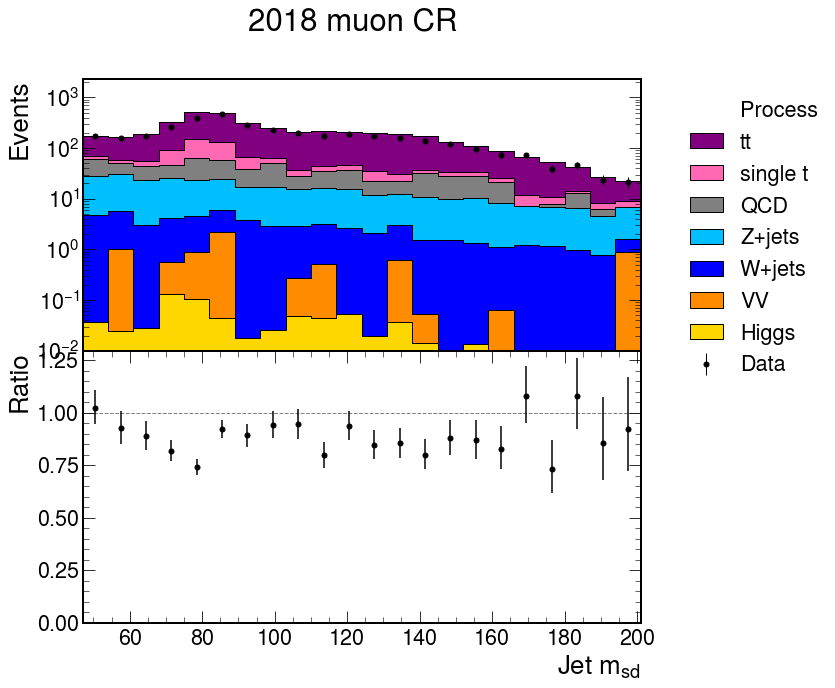

In [10]:
h = templates.sum('ddb1','pt1').integrate('region', 'muoncontrol')
plot_datamc_muoncr(h,year+'/muCR_msd1',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7fd2cf15a160>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


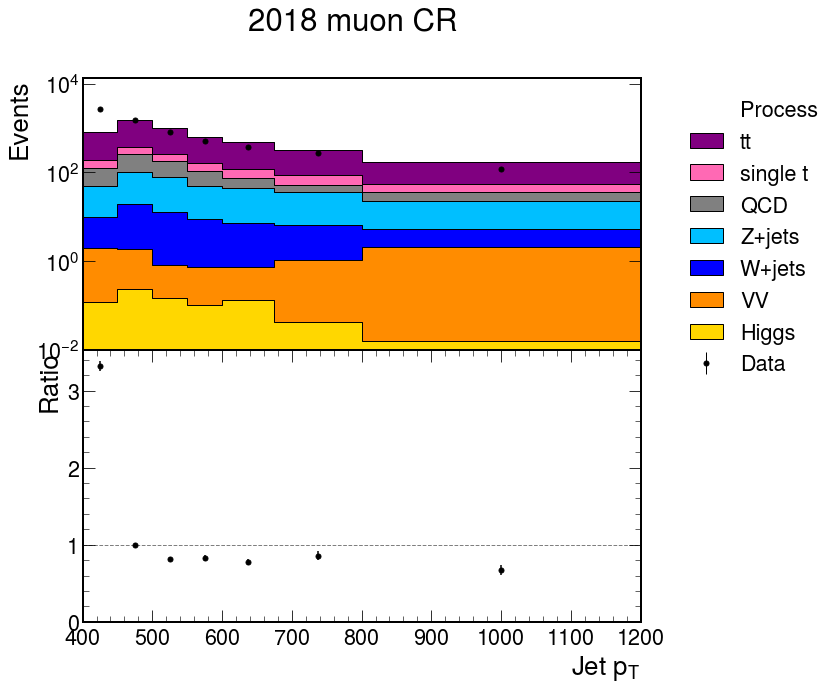

In [11]:
h = mujetkin.integrate('region', 'muoncontrol').sum('msd1','eta1','ddb1')
plot_datamc_muoncr(h,year+'/muCR_pt1',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7fd2cf15a160>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


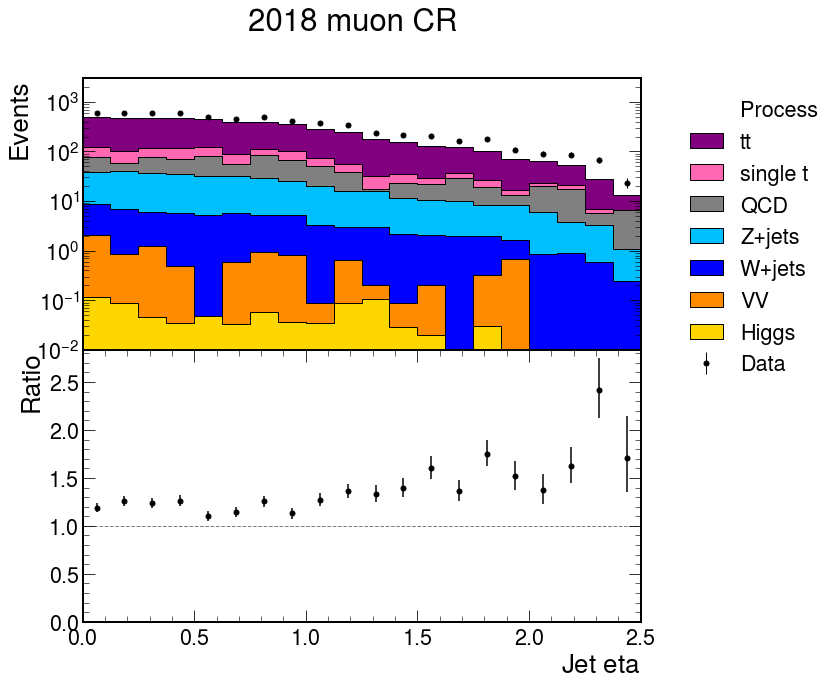

In [12]:
h = mujetkin.integrate('region', 'muoncontrol').sum('msd1','pt1','ddb1')
plot_datamc_muoncr(h,year+'/muCR_eta1',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7fd2cf15a160>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


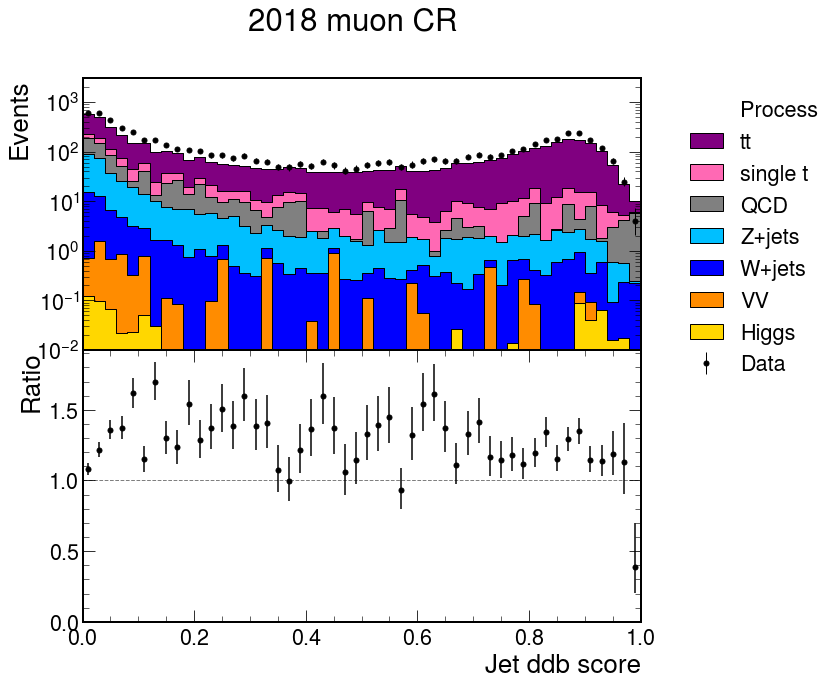

In [13]:
h = mujetkin.integrate('region', 'muoncontrol').sum('msd1','pt1','eta1')
plot_datamc_muoncr(h,year+'/muCR_ddb1',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7fd2cf15a340>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = numpy.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7fd2cf15a340>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_

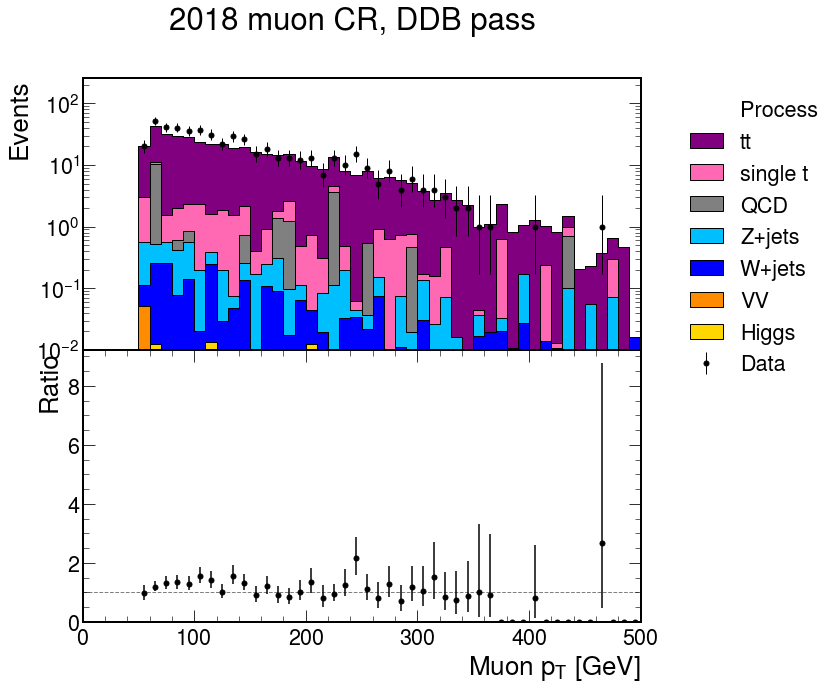

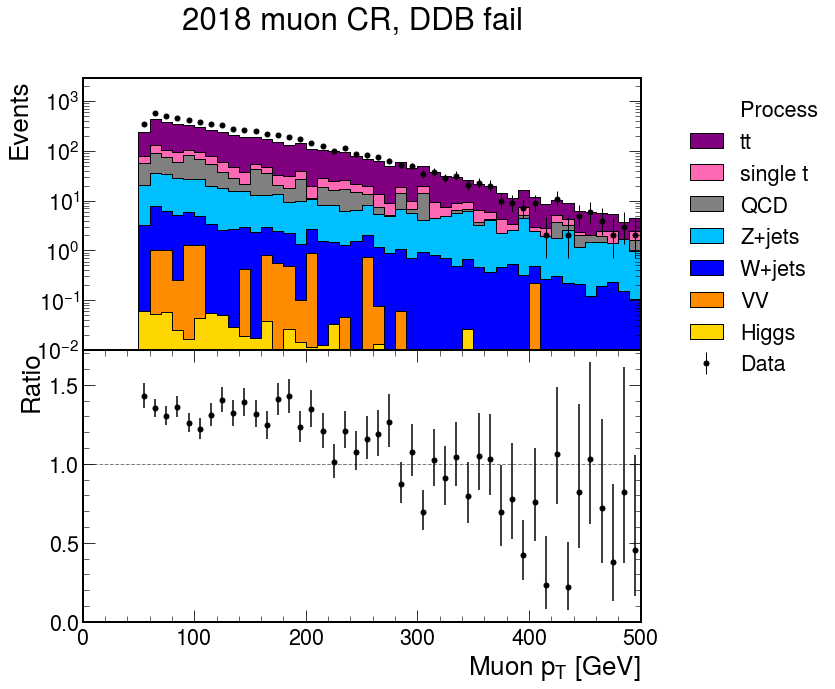

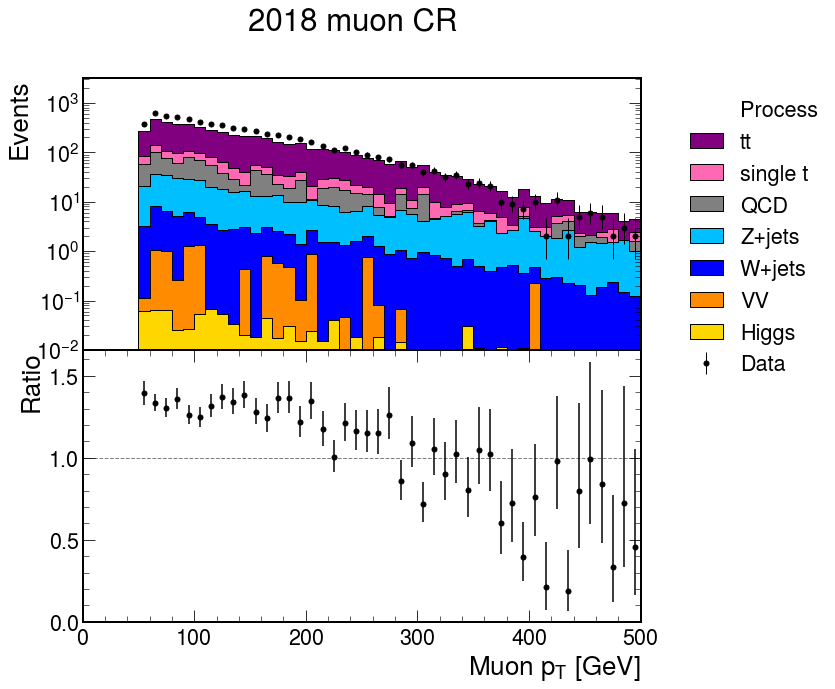

In [14]:
h = muonkin.integrate('region', 'muoncontrol').sum('etamu').integrate('ddb1',int_range=slice(0.89,1))
plot_datamc_muoncr(h,year+'/muCR_ptmu_pass',year+" muon CR, DDB pass")
h = muonkin.integrate('region', 'muoncontrol').sum('etamu').integrate('ddb1',int_range=slice(0,0.89))
plot_datamc_muoncr(h,year+'/muCR_ptmu_fail',year+" muon CR, DDB fail")
h = muonkin.integrate('region', 'muoncontrol').sum('etamu','ddb1')
plot_datamc_muoncr(h,year+'/muCR_ptmu',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7fd2cf15a340>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = numpy.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7fd2cf15a340>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_

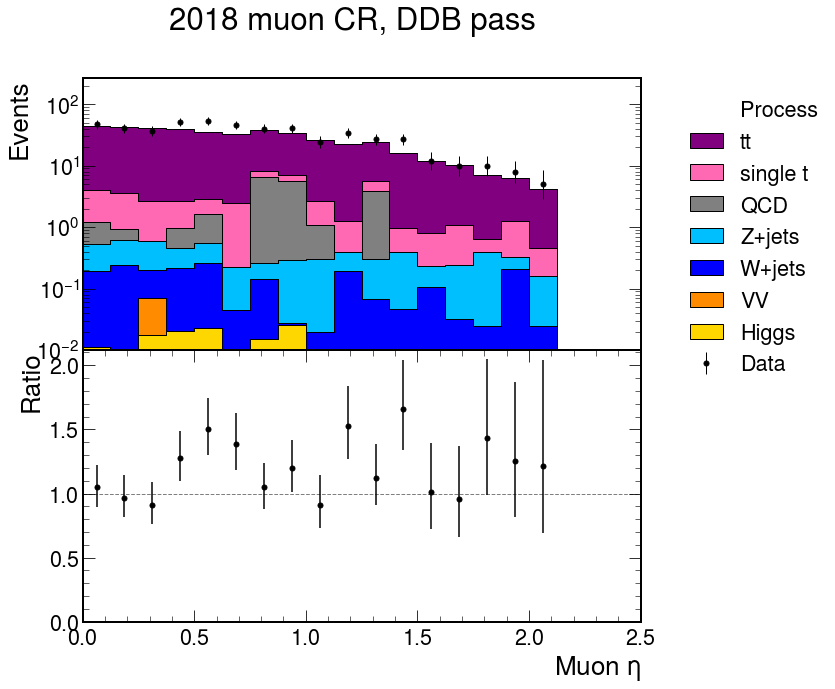

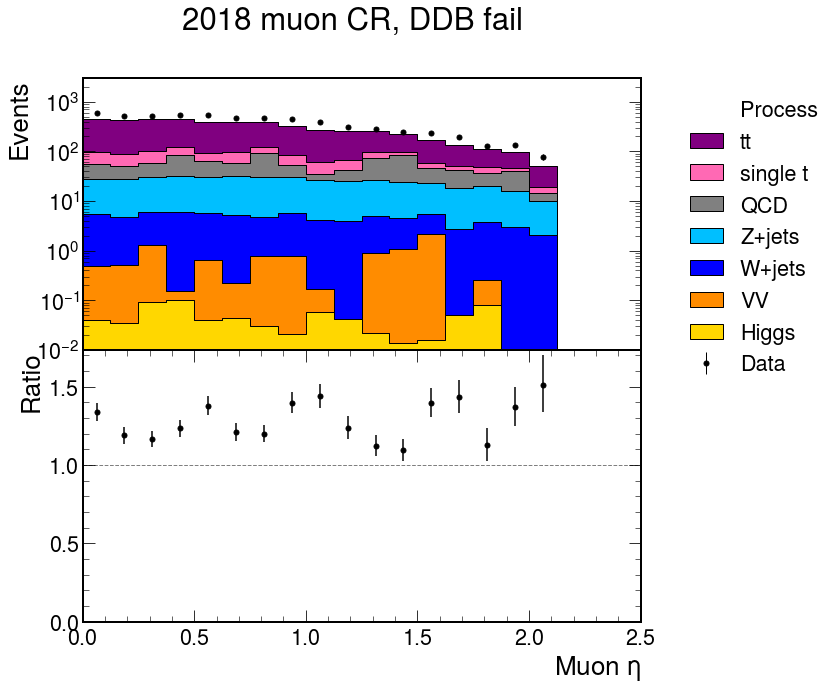

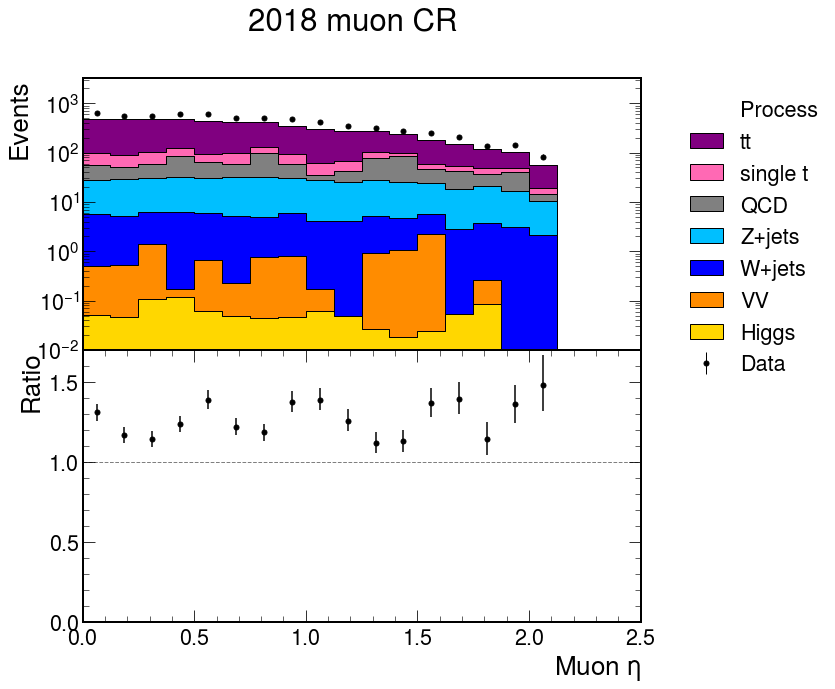

In [15]:
h = muonkin.integrate('region', 'muoncontrol').sum('ptmu').integrate('ddb1',int_range=slice(0.89,1))
plot_datamc_muoncr(h,year+'/muCR_etamu_pass',year+" muon CR, DDB pass")
h = muonkin.integrate('region', 'muoncontrol').sum('ptmu').integrate('ddb1',int_range=slice(0,0.89))
plot_datamc_muoncr(h,year+'/muCR_etamu_fail',year+" muon CR, DDB fail")
h = muonkin.integrate('region', 'muoncontrol').sum('ptmu','ddb1')
plot_datamc_muoncr(h,year+'/muCR_etamu',year+" muon CR")